## 📄 Fichier `supply_chain_simplified.py`


Réimplémentation simplifiée de l'article:
"An Open Tool-Set for Simulation, Design-Space Exploration and 
Optimization of Supply Chains and Inventory Problems"

Simplifications apportées:
1. Réseau réduit: 1 fabricant, 2 distributeurs, 1 détaillant
2. Paramètres réduits: 4 au lieu de 8 (S_D, s_D, S_R, s_R)
3. Durée simulation: 100 jours au lieu de 1000
4. Nombre de runs: 50 au lieu de 200

Justification: Ces simplifications permettent une exécution sur PC modeste
tout en conservant la logique et les concepts clés du modèle.


In [24]:

%pip install simpy

# ============================================================================
# SECTION 1: IMPORTS ET CONFIGURATION
# ============================================================================

import simpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple, Optional
import time
import warnings
warnings.filterwarnings('ignore')

# Configuration pour reproductibilité
np.random.seed(42)

# Paramètres globaux simplifiés
PARAMS = {
    'lambda': 10,  # Réduit de 20 à 10 pour moins de charge
    'p': 0.5,      # Probabilité de choisir détaillant
    'P': 100,      # Profit par unité
    'H_R': 10,     # Coût de stockage détaillant
    'H_D': 1,      # Coût de stockage distributeur
    'simulation_days': 100,  # Réduit de 1000 à 100
    'num_simulations': 50    # Réduit de 200 à 50
}


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\alaac\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [25]:

# ============================================================================
# SECTION 2: CLASSES DE BASE
# ============================================================================

class InventoryMonitor:
    """
    Moniteur d'inventaire avec calcul de moyenne pondérée dans le temps
    Simplifié pour économiser la mémoire
    """
    def __init__(self, env, initial_level, capacity):
        self.env = env
        self.level = initial_level
        self.capacity = capacity
        self.avg_level = 0
        self.last_time = 0
        self.last_level = initial_level
        
    def update_level(self, new_level):
        """Met à jour le niveau et calcule la moyenne pondérée"""
        current_time = self.env.now
        time_delta = current_time - self.last_time
        
        if time_delta > 0:
            # Moyenne pondérée cumulative
            self.avg_level = (self.avg_level * self.last_time + 
                            self.last_level * time_delta) / current_time
        
        self.last_time = current_time
        self.last_level = new_level
        self.level = new_level


In [26]:

# ============================================================================
# SECTION 3: NŒUDS DE LA CHAÎNE D'APPROVISIONNEMENT
# ============================================================================

class SupplyChainNode:
    """
    Classe de base pour tous les acteurs de la chaîne
    Simplifiée mais conserve la logique essentielle
    """
    def __init__(self, env: simpy.Environment, name: str, 
                 S: Optional[int] = None, s: Optional[int] = None,
                 H: float = 0, suppliers: List = None):
        self.env = env
        self.name = name
        self.S = S  # Capacité inventaire
        self.s = s  # Seuil réapprovisionnement
        self.H = H  # Coût de stockage
        self.suppliers = suppliers or []
        
        # Métriques simplifiées
        self.total_sold = 0
        self.total_ordered = 0
        self.customers_lost = 0
        self.customers_total = 0
        self.holding_costs = []
        self.delivery_costs = []
        
        # Inventaire
        if S is not None:
            self.inventory = InventoryMonitor(env, S, S)
            self.container = simpy.Container(env, capacity=S, init=S)
            self.ordered = False
            # Démarrer surveillance
            env.process(self.monitor_inventory())
            
    def monitor_inventory(self):
        """Surveillance quotidienne de l'inventaire"""
        while True:
            yield self.env.timeout(1)  # Vérification quotidienne
            
            # Enregistrer coût de stockage
            current_level = self.container.level
            self.inventory.update_level(current_level)
            self.holding_costs.append(current_level * self.H)
            
            # Réapprovisionner si nécessaire
            if current_level < self.s and not self.ordered:
                self.env.process(self.order())
                self.ordered = True

    def order(self):
        """Logique de commande simplifiée"""
        if not self.suppliers:
            return
            
        # Sélection du fournisseur (simplifié: premier disponible)
        supplier = self.suppliers[0]
        quantity = self.S - self.container.level
        
        # Essayer de commander
        if hasattr(supplier, 'container'):
            if supplier.container.level >= quantity:
                yield supplier.container.get(quantity)
                supplier.total_sold += quantity
                
                # Délai de livraison simplifié (2 jours)
                yield self.env.timeout(2)
                
                yield self.container.put(quantity)
                self.total_ordered += quantity
                self.delivery_costs.append(1000)  # Coût fixe simplifié
                
        self.ordered = False


In [27]:

# ============================================================================
# SECTION 4: ACTEURS SPÉCIFIQUES
# ============================================================================

class Manufacturer(SupplyChainNode):
    """Fabricant avec capacité illimitée"""
    def __init__(self, env, name="Manufacturer"):
        super().__init__(env, name)
        # Capacité illimitée simulée
        self.container = simpy.Container(env, capacity=float('inf'), 
                                       init=float('inf'))

class Distributor(SupplyChainNode):
    """Distributeur avec gestion d'inventaire"""
    def __init__(self, env, name, S, s, H=1, manufacturer=None):
        super().__init__(env, name, S, s, H, [manufacturer] if manufacturer else [])

class Retailer(SupplyChainNode):
    """Détaillant en contact avec les clients"""
    def __init__(self, env, name, S, s, H=10, distributors=None):
        super().__init__(env, name, S, s, H, distributors or [])
        self.profit_per_unit = PARAMS['P']


In [28]:

# ============================================================================
# SECTION 5: GÉNÉRATEUR DE CLIENTS
# ============================================================================

def customer_arrivals(env, retailers, arrival_rate):
    """Génère des arrivées de clients selon processus de Poisson"""
    customer_id = 0
    
    while True:
        # Temps entre arrivées (exponentiel)
        yield env.timeout(np.random.exponential(1/arrival_rate))
        
        customer_id += 1
        retailer = np.random.choice(retailers)
        demand = np.random.randint(1, 6)  # Réduit de 10 à 5
        
        # Tentative d'achat
        retailer.customers_total += 1
        if retailer.container.level >= demand:
            yield retailer.container.get(demand)
            retailer.total_sold += demand
        else:
            retailer.customers_lost += 1


In [29]:

# ============================================================================
# SECTION 6: FONCTION DE SIMULATION
# ============================================================================

def run_single_simulation(S_D, s_D, S_R, s_R, 
                         sim_days=100, print_log=False):
    """
    Execute une simulation avec les paramètres donnés
    Retourne les métriques de performance
    """
    # Créer environnement
    env = simpy.Environment()
    
    # Créer réseau simplifié
    manufacturer = Manufacturer(env)
    
    # 2 distributeurs
    dist1 = Distributor(env, "D1", S_D, s_D, 1, manufacturer)
    dist2 = Distributor(env, "D2", S_D, s_D, 1, manufacturer)
    
    # 1 détaillant (au lieu de 2)
    retailer = Retailer(env, "R1", S_R, s_R, 10, [dist1, dist2])
    
    # Démarrer arrivées clients
    env.process(customer_arrivals(env, [retailer], PARAMS['lambda']))
    
    # Exécuter simulation
    env.run(until=sim_days)
    
    # Calculer métriques
    metrics = calculate_metrics(retailer, [dist1, dist2], sim_days)
    
    return metrics

def calculate_metrics(retailer, distributors, days):
    """Calcule les métriques de performance"""
    # Revenus
    revenue = retailer.total_sold * PARAMS['P']
    
    # Coûts de stockage
    holding_cost_retailer = sum(retailer.holding_costs)
    holding_cost_dist = sum(sum(d.holding_costs) for d in distributors)
    total_holding = holding_cost_retailer + holding_cost_dist
    
    # Coûts de livraison
    delivery_cost = sum(retailer.delivery_costs)
    for d in distributors:
        delivery_cost += sum(d.delivery_costs)
    
    # Profit net
    net_profit = revenue - total_holding - delivery_cost
    
    # Taux de service
    service_level = 1 - (retailer.customers_lost / 
                        max(1, retailer.customers_total))
    
    # Niveau d'inventaire moyen
    avg_inventory = retailer.inventory.avg_level
    for d in distributors:
        avg_inventory += d.inventory.avg_level
    
    return {
        'revenue_per_day': revenue / days,
        'holding_cost_per_day': total_holding / days,
        'delivery_cost_per_day': delivery_cost / days,
        'net_profit_per_day': net_profit / days,
        'service_level': service_level,
        'avg_inventory': avg_inventory,
        'customers_lost_rate': retailer.customers_lost / 
                              max(1, retailer.customers_total)
    }


In [30]:
# ============================================================================
# SECTION 7: ANALYSE MULTI-RUNS
# ============================================================================

def run_multiple_simulations(S_D, s_D, S_R, s_R, 
                           num_runs=50, sim_days=100):
    """Execute plusieurs simulations et retourne statistiques"""
    results = []
    
    print(f"Exécution de {num_runs} simulations...")
    start_time = time.time()
    
    for i in range(num_runs):
        if i % 10 == 0:
            print(f"  Simulation {i+1}/{num_runs}")
        
        metrics = run_single_simulation(S_D, s_D, S_R, s_R, sim_days)
        results.append(metrics)
    
    # Calculer moyennes et écarts-types
    df = pd.DataFrame(results)
    stats = {
        'mean': df.mean().to_dict(),
        'std': df.std().to_dict(),
        'rse': (df.std() / df.mean() * 100).to_dict()
    }
    
    elapsed = time.time() - start_time
    print(f"Terminé en {elapsed:.1f} secondes")
    
    return stats, df


In [31]:
# ============================================================================
# SECTION 8: EXPLORATION DE L'ESPACE DE CONCEPTION
# ============================================================================

def explore_design_space():
    """
    Explore l'espace de conception de manière simplifiée
    Grille 3x3 au lieu de 4x4 pour chaque paramètre
    """
    # Définir grilles de recherche (réduites)
    S_D_values = [300, 400, 500]
    s_D_ratios = [0.5, 0.7, 0.9]  # Ratio s/S
    S_R_values = [150, 200, 250]
    s_R_ratios = [0.3, 0.5, 0.7]
    
    results_grid = []
    total_points = len(S_D_values) * len(s_D_ratios) * \
                   len(S_R_values) * len(s_R_ratios)
    
    print(f"Exploration de {total_points} points...")
    point = 0
    
    for S_D in S_D_values:
        for s_D_ratio in s_D_ratios:
            s_D = int(S_D * s_D_ratio)
            
            for S_R in S_R_values:
                for s_R_ratio in s_R_ratios:
                    s_R = int(S_R * s_R_ratio)
                    point += 1
                    
                    print(f"\nPoint {point}/{total_points}: "
                          f"S_D={S_D}, s_D={s_D}, S_R={S_R}, s_R={s_R}")
                    
                    # Runs réduits pour exploration
                    stats, _ = run_multiple_simulations(
                        S_D, s_D, S_R, s_R, 
                        num_runs=20,  # Encore réduit pour exploration
                        sim_days=50   # Jours réduits aussi
                    )
                    
                    results_grid.append({
                        'S_D': S_D, 's_D': s_D,
                        'S_R': S_R, 's_R': s_R,
                        'net_profit': stats['mean']['net_profit_per_day'],
                        'service_level': stats['mean']['service_level'],
                        'rse_profit': stats['rse']['net_profit_per_day']
                    })
    
    return pd.DataFrame(results_grid)


In [32]:

# ============================================================================
# SECTION 9: VISUALISATIONS
# ============================================================================

def plot_results(df_results):
    """Crée visualisations des résultats"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. Heatmap profit net
    pivot = df_results.pivot_table(
        index='s_R', columns='S_R', values='net_profit'
    )
    sns.heatmap(pivot, annot=True, fmt='.0f', ax=axes[0,0], cmap='RdYlGn')
    axes[0,0].set_title('Profit Net par jour (Rs)')
    
    # 2. Service level
    pivot_service = df_results.pivot_table(
        index='s_D', columns='S_D', values='service_level'
    )
    sns.heatmap(pivot_service, annot=True, fmt='.2f', ax=axes[0,1], cmap='Blues')
    axes[0,1].set_title('Niveau de Service')
    
    # 3. Scatter profit vs service
    axes[1,0].scatter(df_results['service_level'], 
                      df_results['net_profit'],
                      alpha=0.6)
    axes[1,0].set_xlabel('Niveau de Service')
    axes[1,0].set_ylabel('Profit Net')
    axes[1,0].set_title('Trade-off Service vs Profit')
    
    # 4. Distribution RSE
    axes[1,1].hist(df_results['rse_profit'], bins=20, alpha=0.7)
    axes[1,1].set_xlabel('RSE du Profit (%)')
    axes[1,1].set_ylabel('Fréquence')
    axes[1,1].set_title('Précision des Estimations')
    
    plt.tight_layout()
    plt.savefig('resultats_exploration.png', dpi=150)
    plt.show()


In [33]:

# ============================================================================
# SECTION 10: ANALYSE COÛT-PRÉCISION
# ============================================================================

def analyze_cost_accuracy():
    """Analyse le compromis entre coût computationnel et précision"""
    num_runs_list = [10, 20, 50, 100]
    sim_days_list = [50, 100, 200]
    
    # Paramètres fixes pour le test
    S_D, s_D, S_R, s_R = 400, 300, 200, 100
    
    results = []
    
    for days in sim_days_list:
        for runs in num_runs_list:
            print(f"\nTest: {runs} runs, {days} jours")
            
            start = time.time()
            stats, _ = run_multiple_simulations(
                S_D, s_D, S_R, s_R, runs, days
            )
            elapsed = time.time() - start
            
            results.append({
                'runs': runs,
                'days': days,
                'time': elapsed,
                'rse': stats['rse']['net_profit_per_day']
            })
    
    df_cost = pd.DataFrame(results)
    
    # Visualisation
    plt.figure(figsize=(10, 6))
    for days in sim_days_list:
        data = df_cost[df_cost['days'] == days]
        plt.plot(data['time'], data['rse'], 
                marker='o', label=f'{days} jours')
    
    plt.xlabel('Temps de calcul (secondes)')
    plt.ylabel('RSE (%)')
    plt.title('Compromis Temps-Précision')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('cout_precision.png', dpi=150)
    plt.show()
    
    return df_cost


In [34]:


# ============================================================================
# SECTION 11: FONCTION PRINCIPALE
# ============================================================================

def main():
    """Fonction principale pour notebook Jupyter"""
    print("=== Réimplémentation Simplifiée Supply Chain ===\n")
    
    # 1. Test de base
    print("1. Test de simulation unique...")
    metrics = run_single_simulation(400, 300, 200, 100, sim_days=100)
    print(f"Profit net: {metrics['net_profit_per_day']:.2f} Rs/jour")
    print(f"Niveau de service: {metrics['service_level']:.2%}")
    
    # 2. Analyse statistique
    print("\n2. Analyse avec multiples runs...")
    stats, df_runs = run_multiple_simulations(400, 300, 200, 100)
    print(f"Profit moyen: {stats['mean']['net_profit_per_day']:.2f} "
          f"± {stats['std']['net_profit_per_day']:.2f}")
    print(f"RSE: {stats['rse']['net_profit_per_day']:.1f}%")
    
    # 3. Analyse coût-précision
    print("\n3. Analyse coût-précision...")
    df_cost = analyze_cost_accuracy()
    
    # 4. Exploration (optionnel car long)
    user_input = input("\nExplorer l'espace complet? (y/n): ")
    if user_input.lower() == 'y':
        df_results = explore_design_space()
        plot_results(df_results)
        
        # Trouver optimum
        best = df_results.loc[df_results['net_profit'].idxmax()]
        print(f"\nMeilleure configuration trouvée:")
        print(f"S_D={best['S_D']}, s_D={best['s_D']}, "
              f"S_R={best['S_R']}, s_R={best['s_R']}")
        print(f"Profit: {best['net_profit']:.2f} Rs/jour")
        print(f"Service: {best['service_level']:.2%}")
    
    print("\n=== Simulation terminée ===")


=== Réimplémentation Simplifiée Supply Chain ===

1. Test de simulation unique...
Profit net: 894.90 Rs/jour
Niveau de service: 99.71%

2. Analyse avec multiples runs...
Exécution de 50 simulations...
  Simulation 1/50
  Simulation 11/50
  Simulation 21/50
  Simulation 31/50
  Simulation 41/50
Terminé en 1.0 secondes
Profit moyen: 789.26 ± 105.17
RSE: 13.3%

3. Analyse coût-précision...

Test: 10 runs, 50 jours
Exécution de 10 simulations...
  Simulation 1/10
Terminé en 0.1 secondes

Test: 20 runs, 50 jours
Exécution de 20 simulations...
  Simulation 1/20
  Simulation 11/20
Terminé en 0.2 secondes

Test: 50 runs, 50 jours
Exécution de 50 simulations...
  Simulation 1/50
  Simulation 11/50
  Simulation 21/50
  Simulation 31/50
  Simulation 41/50
Terminé en 0.5 secondes

Test: 100 runs, 50 jours
Exécution de 100 simulations...
  Simulation 1/100
  Simulation 11/100
  Simulation 21/100
  Simulation 31/100
  Simulation 41/100
  Simulation 51/100
  Simulation 61/100
  Simulation 71/100
  Si

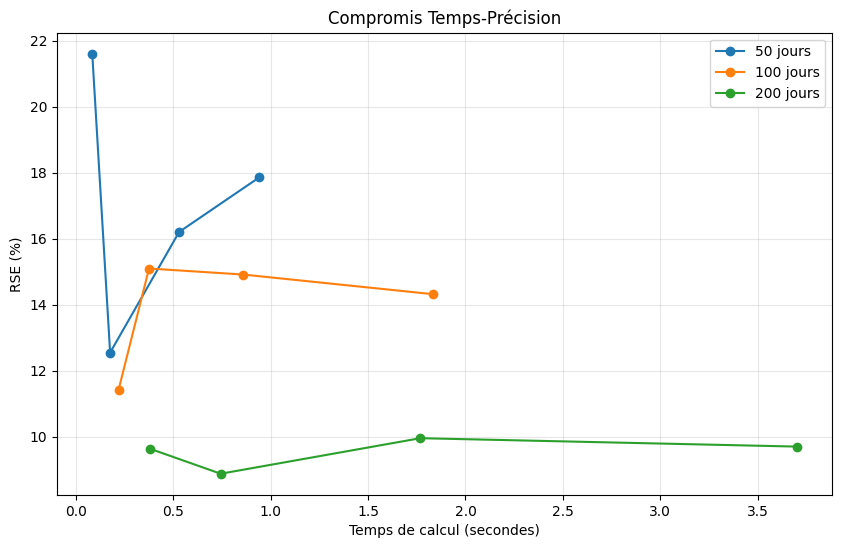

Exploration de 81 points...

Point 1/81: S_D=300, s_D=150, S_R=150, s_R=45
Exécution de 20 simulations...
  Simulation 1/20
  Simulation 11/20
Terminé en 0.2 secondes

Point 2/81: S_D=300, s_D=150, S_R=150, s_R=75
Exécution de 20 simulations...
  Simulation 1/20
  Simulation 11/20
Terminé en 0.2 secondes

Point 3/81: S_D=300, s_D=150, S_R=150, s_R=105
Exécution de 20 simulations...
  Simulation 1/20
  Simulation 11/20
Terminé en 0.2 secondes

Point 4/81: S_D=300, s_D=150, S_R=200, s_R=60
Exécution de 20 simulations...
  Simulation 1/20
  Simulation 11/20
Terminé en 0.2 secondes

Point 5/81: S_D=300, s_D=150, S_R=200, s_R=100
Exécution de 20 simulations...
  Simulation 1/20
  Simulation 11/20
Terminé en 0.2 secondes

Point 6/81: S_D=300, s_D=150, S_R=200, s_R=140
Exécution de 20 simulations...
  Simulation 1/20
  Simulation 11/20
Terminé en 0.2 secondes

Point 7/81: S_D=300, s_D=150, S_R=250, s_R=75
Exécution de 20 simulations...
  Simulation 1/20
  Simulation 11/20
Terminé en 0.2 secon

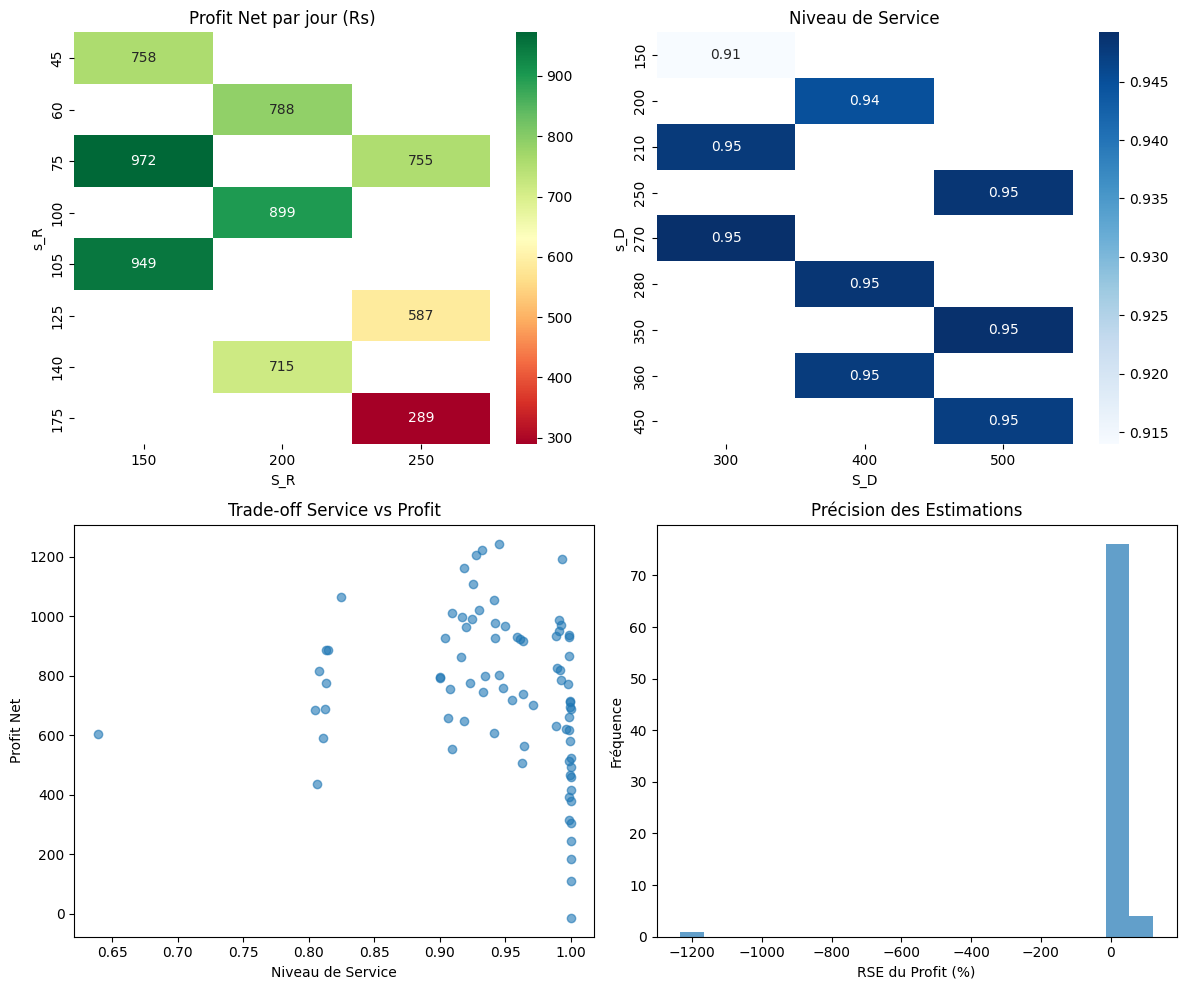


Meilleure configuration trouvée:
S_D=300.0, s_D=150.0, S_R=150.0, s_R=105.0
Profit: 1243.87 Rs/jour
Service: 94.56%

=== Simulation terminée ===


'\n# Cellule 1: Configuration\n%matplotlib inline\nimport warnings\nwarnings.filterwarnings(\'ignore\')\n\n# Cellule 2: Test simple\nmetrics = run_single_simulation(400, 300, 200, 100)\nprint(f"Résultats: {metrics}")\n\n# Cellule 3: Analyse statistique\nstats, df = run_multiple_simulations(400, 300, 200, 100, num_runs=30)\ndf.describe()\n\n# Cellule 4: Visualisation\ndf.hist(figsize=(12, 8), bins=20)\nplt.tight_layout()\nplt.show()\n\n# Cellule 5: Exploration (attention: ~10 minutes)\ndf_results = explore_design_space()\nplot_results(df_results)\n'

In [35]:


# ============================================================================
# SECTION 12: POUR JUPYTER NOTEBOOK
# ============================================================================

if __name__ == "__main__":
    # Pour exécution directe Python
    main()

# Pour Jupyter, décommentez et exécutez cellule par cellule:
"""
# Cellule 1: Configuration
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Cellule 2: Test simple
metrics = run_single_simulation(400, 300, 200, 100)
print(f"Résultats: {metrics}")

# Cellule 3: Analyse statistique
stats, df = run_multiple_simulations(400, 300, 200, 100, num_runs=30)
df.describe()

# Cellule 4: Visualisation
df.hist(figsize=(12, 8), bins=20)
plt.tight_layout()
plt.show()

# Cellule 5: Exploration (attention: ~10 minutes)
df_results = explore_design_space()
plot_results(df_results)
"""